<a href="https://colab.research.google.com/github/gustacoutinho/DataAnalysis-EnergyAndPIB/blob/main/Pergunta_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 3: Qual país tem a probabilidade de um crescimento no PIB dada a correlação com o consumo de energia primária?

In [38]:
!pip install xlrd==1.2.0
from google.colab import drive
drive.mount("/content/drive/", force_remount=True)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Mounted at /content/drive/


In [39]:
# Importação das Bibliotecas usadas
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
import numpy as np
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn import linear_model
from sklearn.model_selection import train_test_split

In [40]:
sns.set(rc={'figure.figsize':(20,10)})

In [41]:
countrys = ['Brazil', 'Bolivia', 'Chile', 'Argentina', 'Peru']

scaler = preprocessing.StandardScaler()

#Função para dropar as colunas de pais e ano
def prepare(df):
  return df.drop(['country', 'year'], axis=1)

#Função de Normalização
def normalize(df):
  df_temp = df.copy()
  X = prepare(df_temp)
  return scaler.fit_transform(X)

#Função para filtrar o dataframe pelo países desejado
def filtraCountrysdf(df, countrys):
  return df[df['country'].isin(countrys)]

#Função para filtrar o dataframe pelo país desejado
def filtraCountrydf(df, country):
  df_mask = df['country'] == country
  return df[df_mask]

#Função para criar uma lista de dataframe
def createListDF():
  DFS = {}
  for i in range(len(countrys)):
    DFS.update({countrys[i]: pd.DataFrame()})
  return DFS 
  
#Função para printar a Correlação de Pearson
def pearson(df, name):
  print("Correlação de Pearson de "+name+": \n", df.corr())
DFS = createListDF()

In [42]:
#Função de tratamento da estrutura do dataframe para corresponder com a pergunta
def alteraEstruturadf(df):
  filtered_pib = pd.DataFrame()
  for index, row in df.iterrows():
      for i in range(2010, 2021):
        filtered_pib.loc[i,'PIB'] = row[str(i)]
        filtered_pib.loc[i,'country'] = row['country']

  filtered_pib['PIB'] = filtered_pib['PIB'].str.replace('.','')
  filtered_pib['PIB'] = filtered_pib['PIB'].astype({"PIB": int})
  return filtered_pib

#Função para gerar novo dataframe
def geraNovoDF(df):
  df_novo = pd.DataFrame()
  for x in range(len(countrys)): 
    df_filtrado = pd.DataFrame()
    c = countrys[x]
    df_filtrado = filtraCountrydf(df, c)
    df_temp = alteraEstruturadf(df_filtrado)
    if df_novo.empty:
      df_novo = df_temp
      df_novo.reset_index()
    else:
      df_novo = pd.concat([df_novo, df_temp])

  return df_novo


df_pib = pd.read_csv("drive/MyDrive/Trab/pib.csv", sep=";")
df_pib = df_pib[['Country Name', '2010', '2011', '2012', '2013', '2014', '2015',
                  '2016', '2017', '2018', '2019', '2020']]
df_pib.rename(columns = {'Country Name':'country' }, inplace = True)
df_pib = filtraCountrysdf(df_pib, countrys)
df_pib_final = geraNovoDF(df_pib)
df_pib_final = df_pib_final.reset_index()
df_pib_final.rename(columns = {'index':'year' }, inplace = True)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  if __name__ == '__main__':


In [43]:
#Função para converter Terawatts para Megawatts, para aproximar o maximo possivel com os valores comparativos plotados
def converteParaMega(energy):
  return energy * 1000000
    
#Função de tratamento da energia primaria do dataframe para corresponder com a pergunta
def trataPrimaryEnergy(df):
  df = df.fillna(0)
  for index, row in df.iterrows():
      pe = str(row['primary_energy_consumption'])
      pe = pe + '0'
      pei = pe.replace('.', '')
      pei = int(pei)
      df.at[index,'primary_energy_consumption'] = converteParaMega(pei)
      
  return df

#Leitura csv e selecionamento de dados
df_energy = pd.read_csv("drive/MyDrive/Trab/energy.csv", sep=';')
df_energy = df_energy[['country', 'year', 'primary_energy_consumption' ]]
df_energy = df_energy.drop(df_energy[df_energy.year < 2010].index)
df_energy = df_energy.drop(df_energy[df_energy.year > 2020].index)

filtered_df = filtraCountrysdf(df_energy, countrys)
df_energy_final = trataPrimaryEnergy(filtered_df)
# df_energy_final = df_energy_final.set_index('year')
# df_energy_final

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (5,6,7,8,9,12,13,16,17,20,22,32,33,34,35,38,54,56,66,72,74,80,84,89,91,95,96,97,100,103,109,118,119,120,122,125,126,127) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [44]:
import matplotlib.pyplot as plt
# Realiza a tratativa retirando as colunas que não serão utilizadas e deixando apenas o país alvo do teste
df_merge2 = pd.merge(df_pib_final, df_energy_final, how='outer')
df_merge2 = df_merge2[df_merge2.country == 'Argentina']
df_merge2 = df_merge2.drop(['year', 'country'], axis=1) 

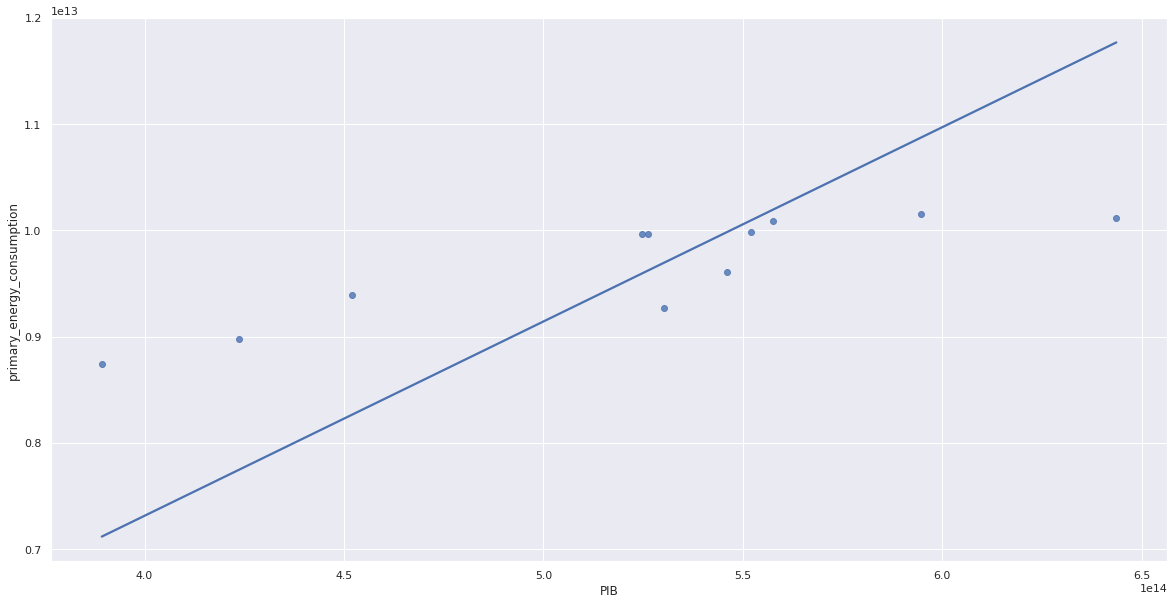

In [45]:
import seaborn as sb 
sb.regplot(x = "PIB", 
            y = "primary_energy_consumption",  
            ci = None, 
            data = df_merge2)

In [46]:
# realizamos a junção dos gráficos de energia com pib dos respectivos países e anos
df_pib2 = df_pib_final.copy()
df_energy2 = df_energy_final.copy()
df_merge = pd.merge(df_pib2, df_energy2, how='outer')

In [47]:
# Separa o dataset por país para que seja feita a normalização dos mesmos
df_brazil = df_merge[df_merge.country == 'Brazil']
df_bolivia = df_merge[df_merge.country == 'Bolivia']
df_chile = df_merge[df_merge.country == 'Chile']
df_argentina = df_merge[df_merge.country == 'Argentina']
df_peru = df_merge[df_merge.country == 'Peru']

In [48]:
# É realizada a normalização do dataset utilizando o scaler.fit_transform na função inicializada nos primeiros blocos
df_brazil = normalize(df_brazil)
df_bolivia = normalize(df_bolivia)
df_chile = normalize(df_chile)
df_argentina = normalize(df_argentina)
df_peru = normalize(df_peru)

In [49]:
# Com os dados já normalizados, setamos os arrays normalizados em colunas PIB e primary_energy_consumption nos datasets novamente
df_brazil = pd.DataFrame(df_brazil, columns=['PIB', 'primary_energy_consumption'])
df_bolivia = pd.DataFrame(df_bolivia, columns=['PIB', 'primary_energy_consumption'])
df_chile = pd.DataFrame(df_chile, columns=['PIB', 'primary_energy_consumption'])
df_argentina = pd.DataFrame(df_argentina, columns=['PIB', 'primary_energy_consumption'])
df_peru = pd.DataFrame(df_peru, columns=['PIB', 'primary_energy_consumption'])

In [50]:
# realizamos a junção de todos os dados já normalizados
df_merge = pd.merge(df_brazil, df_bolivia, how='outer')
df_merge = pd.merge(df_merge, df_chile, how='outer')
df_merge = pd.merge(df_merge, df_argentina, how='outer')
df_merge = pd.merge(df_merge, df_peru, how='outer')

In [51]:
# inserimos novamente as referências de respectivos países e anos do filtro utilizado
df_merge['country'] = df_pib_final['country'].reset_index(drop=True)
df_merge['year'] = df_pib_final['year'].reset_index(drop=True)

In [52]:
#Aplicação da regressão linear
df_prev = df_merge.copy()
model = linear_model.LinearRegression()

for nome, df in DFS.items():
  test_size = 0.33
  seed = 12
  df_pais = filtraCountrydf(df_prev, nome)
  df_temp = df_pais.copy()
  DFS[nome] = df_temp
  features = df_temp.drop(['PIB', 'country'], axis=1)
  labels = df_pais['PIB']

  X_train, X_test, Y_train, Y_test = train_test_split(features, labels, test_size=test_size, random_state=seed)
  model.fit(X_train, Y_train)
  DFS[nome]['pib_predito'] = model.predict(features)
  result = model.score(X_test, Y_test)

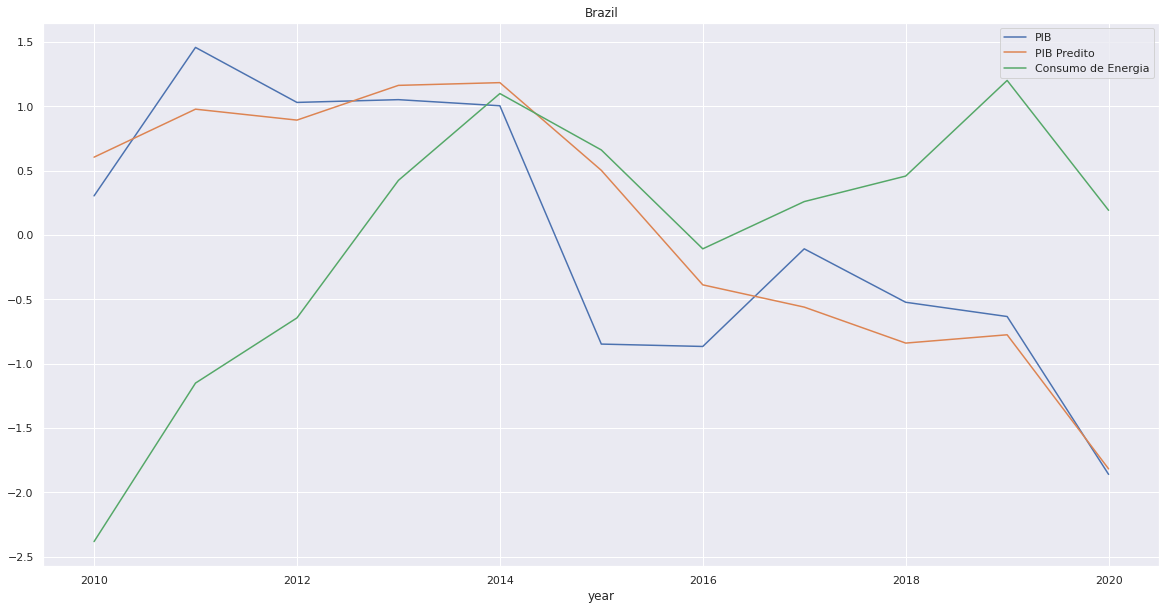

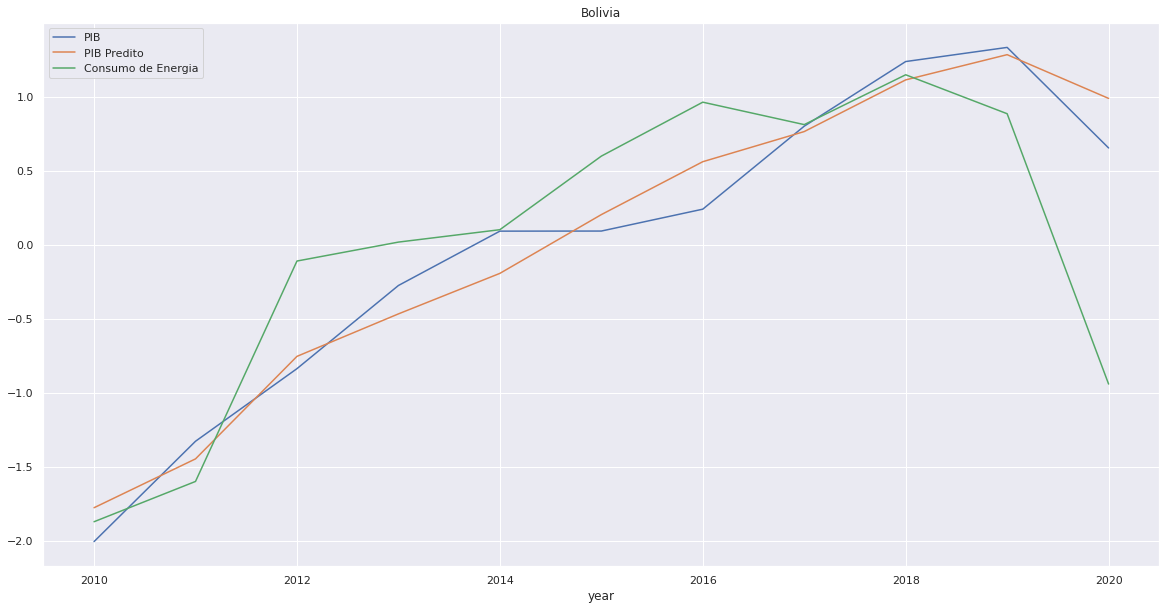

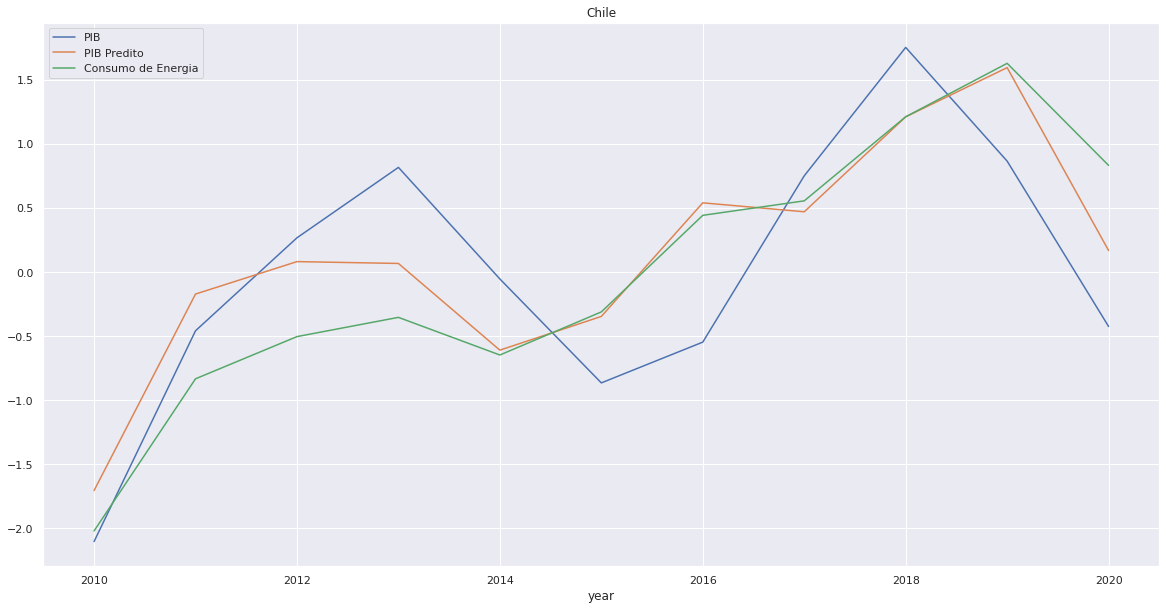

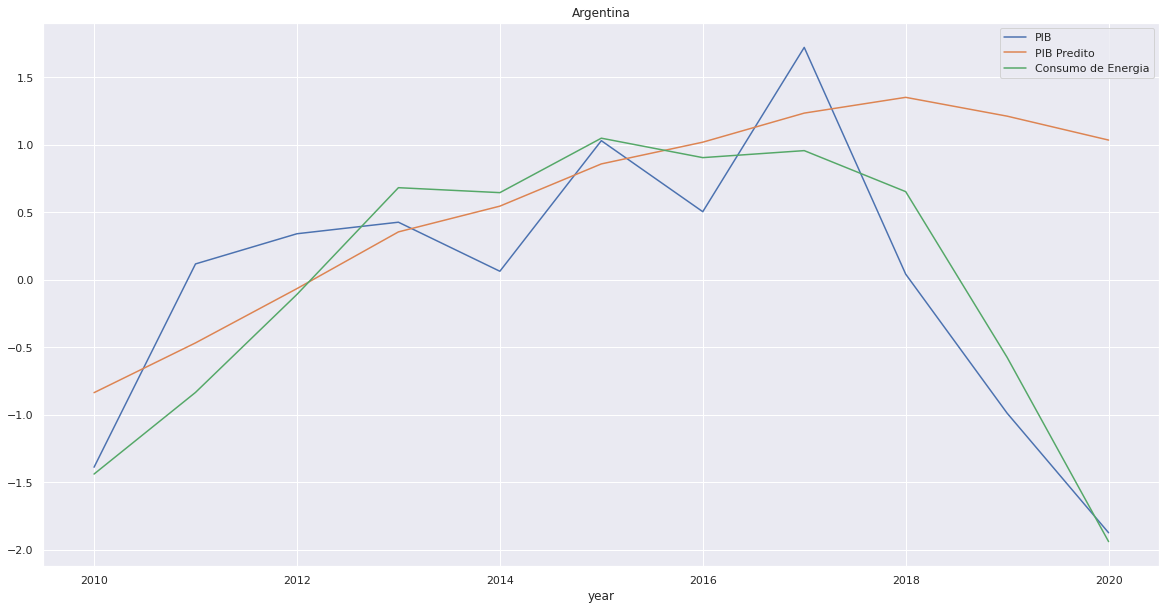

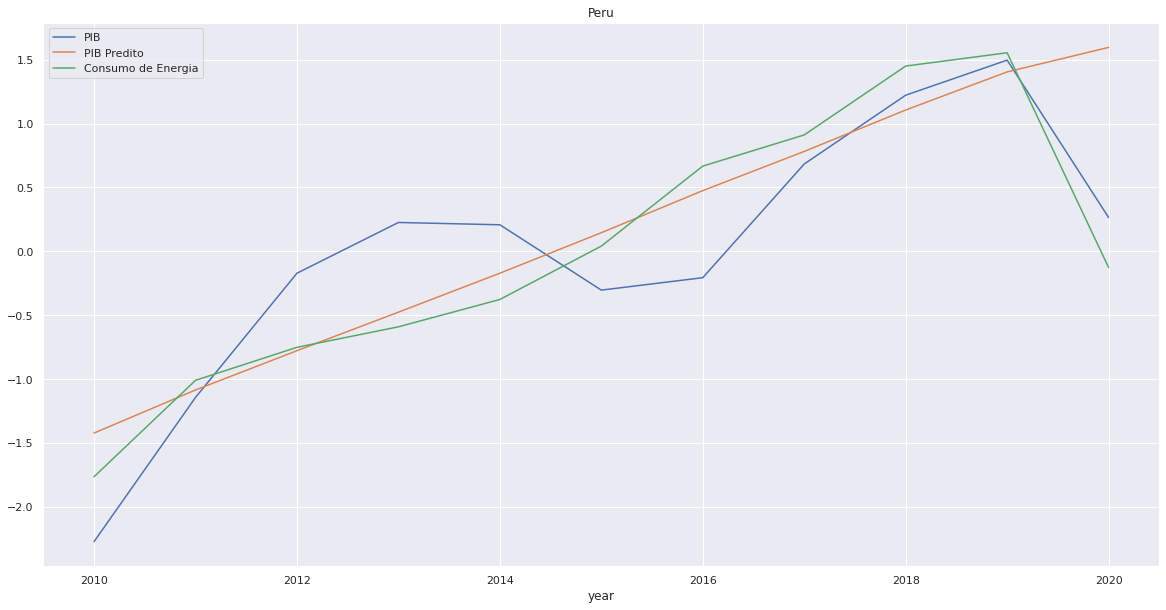

In [53]:
#Exibição do grafico de todos os paises
for nome, df in DFS.items():
  df = df.set_index('year')
  df = df.rename(columns={'PIB': "PIB", 'pib_predito': "PIB Predito", 'primary_energy_consumption': "Consumo de Energia"}, errors="raise")
  df.loc[:,['PIB','PIB Predito', 'Consumo de Energia']].plot(kind='line', title=nome)

In [54]:
#Realiza a Correlação de Pearson utilizando o método pandas.DataFrame.corr
for nome, df in DFS.items():
  print("-------------------------------------------------------------------------------------------------------")
  df = df.rename(columns={'PIB': "PIB", 'primary_energy_consumption': "Consumo de Energia", 'pib_predito': 'PIB Predito'}, errors="raise")

  pearson(df, nome)

-------------------------------------------------------------------------------------------------------
Correlação de Pearson de Brazil: 
                          PIB  Consumo de Energia      year  PIB Predito
PIB                 1.000000           -0.305893 -0.805606     0.873698
Consumo de Energia -0.305893            1.000000  0.691097    -0.263753
year               -0.805606            0.691097  1.000000    -0.879448
PIB Predito         0.873698           -0.263753 -0.879448     1.000000
-------------------------------------------------------------------------------------------------------
Correlação de Pearson de Bolivia: 
                          PIB  Consumo de Energia      year  PIB Predito
PIB                 1.000000            0.807620  0.932719     0.980324
Consumo de Energia  0.807620            1.000000  0.597924     0.773095
year                0.932719            0.597924  1.000000     0.970669
PIB Predito         0.980324            0.773095  0.970669     1.000000
-